_Note: To execute code in this repository, you will need to install the `niwaves` package from GitHub:_

https://github.com/rciric/niwaves

# Subject discriminability with lagged correlations

#### Rastko Ciric<sup>1</sup>

<sup>1</sup>, Department of Bioengineering, Stanford University

Traditionally, studies of functional brain connectivity have aimed to illuminate group effects or nomothetic principles, but the recent surge of interest in precision medicine threatens to upend the prevailing paradigm. Highly sampled datasets<sup>1,2</sup> enable the study of the functional connectome at the level of individuals rather than populations. Recent trends in connectomics highlight the considerable loss of information in the group averaging process<sup>3</sup>, illustrating the utility of a complementary approach to brain mapping that is more idiographic. Work in this burgeoning subdiscipline presents a strong argument that much variance of interest occurs at the level of the individual human<sup>4</sup>, and opens the possibility of fingerprinting individual humans on the basis of their functional connectivity profiles<sup>5</sup>.

Here, I leverage the Midnight Scan Club (MSC) dataset<sup>2</sup>, which includes resting and task data from 10 highly sampled subjects, to investigate the potential of lag patterns as a connectomic "fingerprint". If this is the case, we expect to see a substantially greater amount of shared variance in lag systems within single subjects than are observed between individuals. As we saw previously, lag systems are susceptible to various sources of artefact, so any results presented here should be interpreted with caution.

In [1]:
import glob
import niwaves
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import decomposition, preprocessing

### Sample characteristics

We begin by loading the data. Note that we separately load mean regional BOLD (haemodynamic) time series and motion estimates; because motion exerts inordinate influence on functional connecticity estimates, we will use the motion estimates to generate temporal masks for the purpose of excluding high-motion epochs (FD<sub>Jenkinson</sub> < 0.2) from lag estimates.

* Repetition time/sampling time is 2.2 s.
* Data have been processed using a 36-parameter denoising model<sup>6</sup>.
* Mean time series have been extracted from each node of the 400-region version of the Schaefer parcellation<sup>7</sup>.
* A well-characterised 7-network community structure is used to sort the data<sup>8</sup>.
* Only resting fMRI data are considered here.
* To run lag analysis for the resting data, we use the `lag_analysis` function in `niwaves`, providing as an argument a temporal mask indicating whether each time point is relatively free of motion artefact; frames flagged for high motion are not considered in lag estimates.

In [2]:
subjects = ['sub-MSC{:02}'.format(i) for i in range(1,11)]
sessions = ['ses-func{:02}'.format(i) for i in range(1,11)]
tasks = ['task-rest',
         'task-motor',
         'task-memory*',
         'task-glasslexical']
runs = ['run-01']
ts = {
      task: {
       sub: {
        ses: {
         run: {'roi': glob.glob('data/MSC/ts/{}_{}_{}_run-*_schaefer400_ts.1D'.format(sub, ses, task)),
          'motion': glob.glob('data/MSC/motion/{}_{}_{}_run-*_relRMS.1D'.format(sub, ses, task))
         } for run in runs
        } for ses in sessions
       } for sub in subjects
      } for task in tasks
     }

In [3]:
community = pd.read_table('data/network/schaefer400x7CommunityAffiliation.1D', header=None)

In [4]:
# Rest
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
    ts_rest_c = reduce(lambda x, y: pd.concat([x, y]), ts_rest.values())
    ts_mo_c = reduce(lambda x, y: pd.concat([x, y]), ts_motion.values())
    tmask_rest[sub] = ts_mo_c < 0.2
    lags_rest[sub], peaks_rest[sub] = niwaves.lag_analysis(timeseries1=ts_rest_c.values,
                                                           tmask=tmask_rest[sub].values,
                                                           sample_time=2.2,
                                                           min_block=10,
                                                           lagmax=3)

Now that we've run the subject-level lag analysis, let's take a look at the subject-specific lag matrices. Results for the 10 subjects are displayed in order below. Each subject's temporal mask is also displayed above the subject's lag matrix and distribution to illustrate the differences in sampling between subjects (a potential source of error). Based on results from the previous investigation, we can tentatively conjecture that each subject is sufficiently sampled for convergence of the lag distribution. (Again, I underscore that this in no way implies that the values in lag matrix itself have converged.)

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


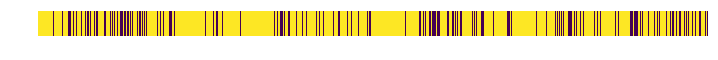

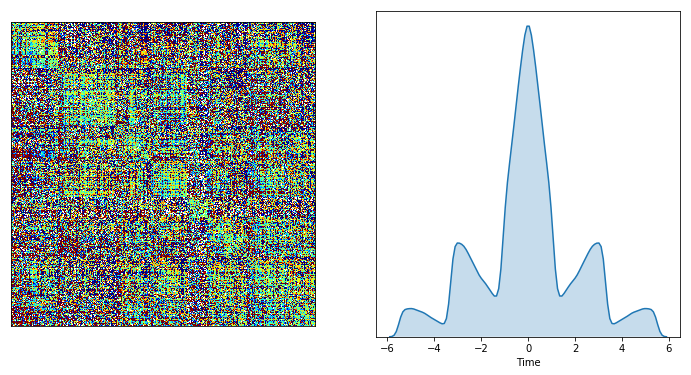

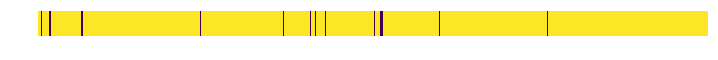

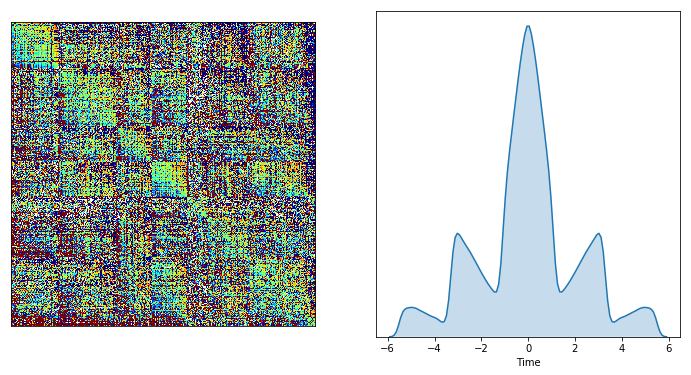

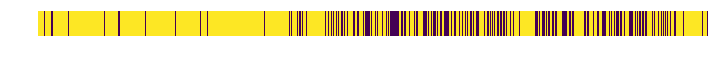

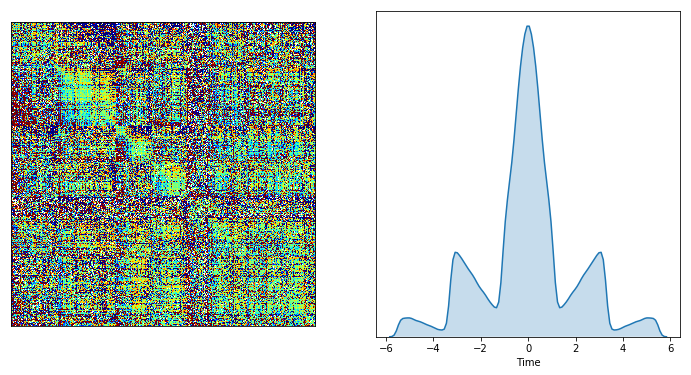

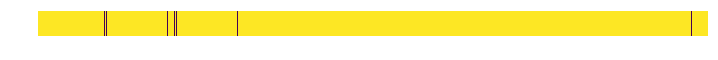

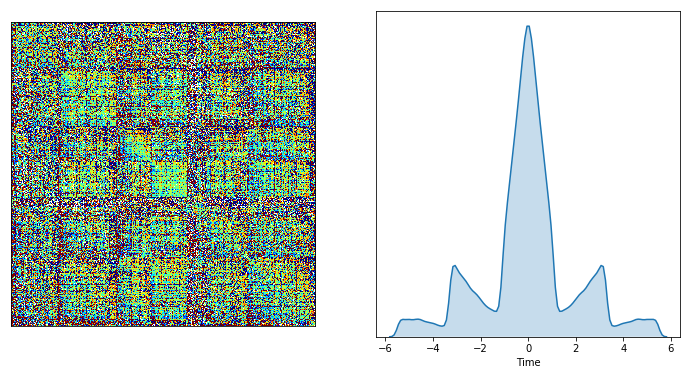

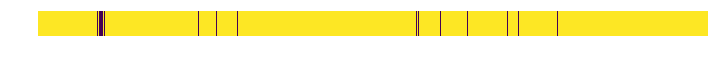

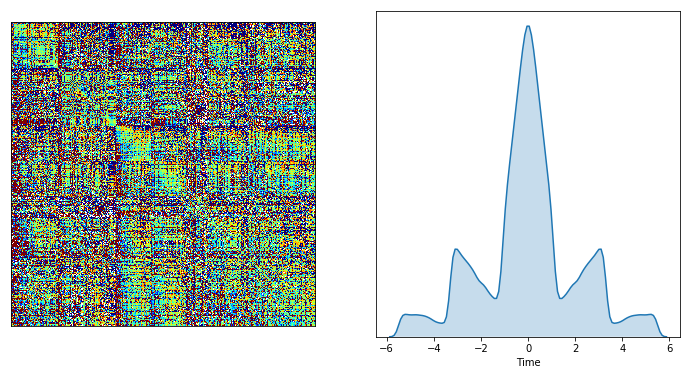

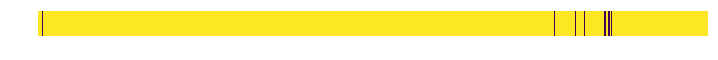

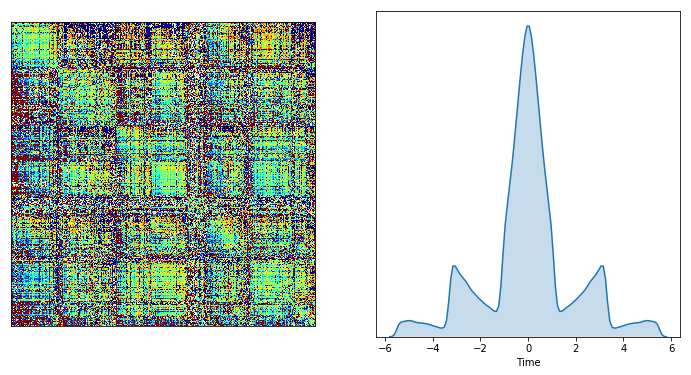

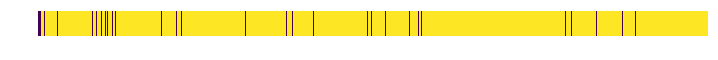

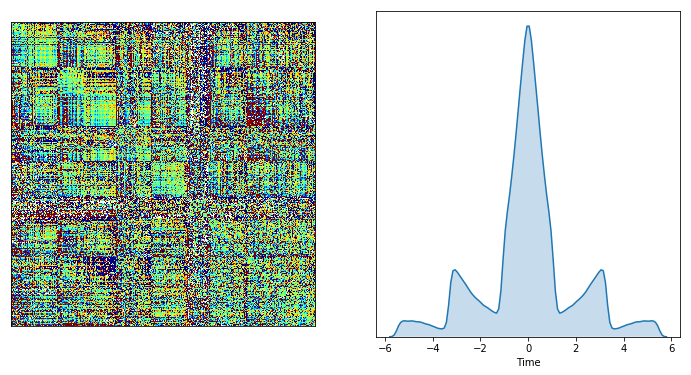

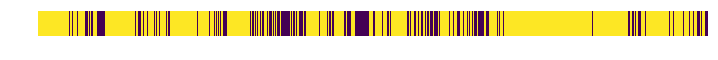

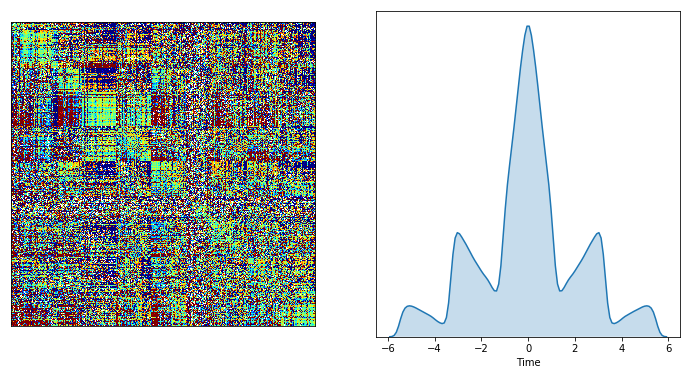

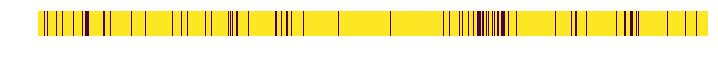

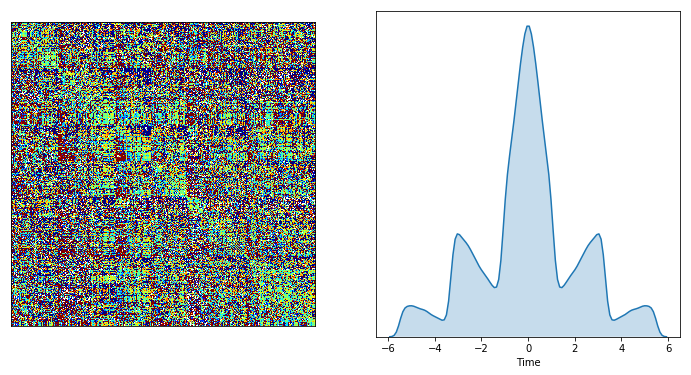

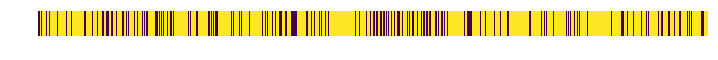

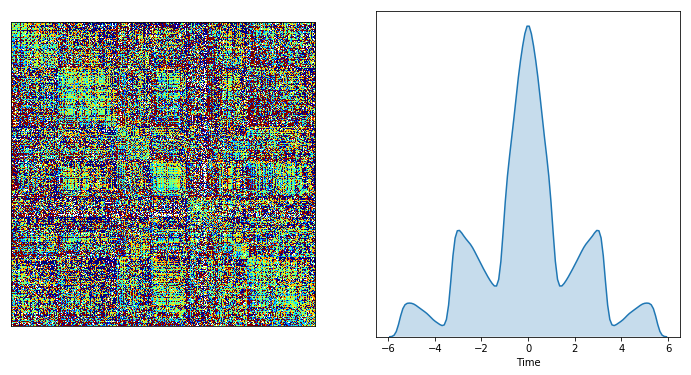

In [5]:
for sub in subjects:
    plt.figure(figsize=(12,1))
    plt.imshow(tmask_rest[sub].values.T, aspect=300)
    plt.axis('off')
    niwaves.lag_sort(lags_rest[sub], community=community)

It's evident above that there is considerable variability between subjects. Let's look, for instance, at lags between nodes in the same community (functional network). In the above figures, within-community lags are arrayed about the diagonal. Some subjects have highly sequential lag systems within certain functional networks. That is to say, signal appears to propagate in a fairly stereotyped sequence  within a network. Compare network 7 (the default mode network, at the bottom right of each matrix) across subjects 9 and 10 (the last two matrices plotted above). In general, subject 10 qualitatively appears to have considerably greater order within the DMN than does subject 9. This observation of sequential signal flow within networks parallels reports of _lag thread motifs_<sup>9</sup>, and Mitra and colleagues have suggested that it might underpin what scientists typically interpret as functional connectivity.

Next, let's compare the individual-level networks estimated above against a group average. Below, we take the mean over the 10 subjects and plot the lag matrix and distribution of latencies in the same way that we've previously plotted subject-specific matrices. Beneath the group-level plot, we additionally prepare a correlation plot between subject-level lag patterns to illustrate common variance between subjects.

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


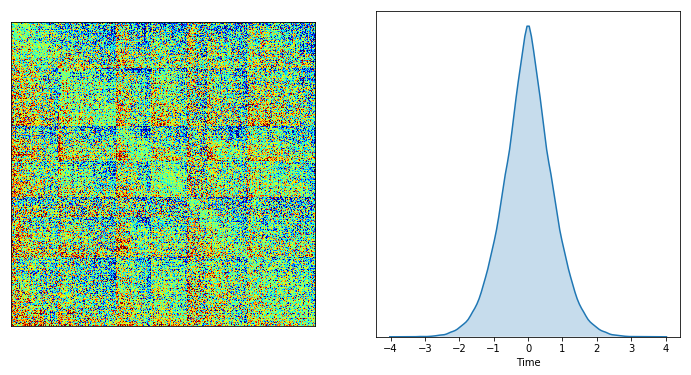

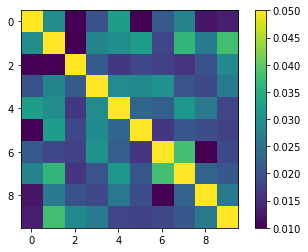

In [6]:
group = np.zeros([len(subjects), len(community), len(community)])
groupr = {}
#np.zeros([len(subjects), len(community) * len(community)])
for i, sub in enumerate(subjects):
    group[i,:,:] = lags_rest[sub]
    groupr[sub] = lags_rest[sub].ravel()
groupmean = np.nanmean(group, axis=0).squeeze()
niwaves.lag_sort(groupmean, community=community)
plt.figure()
plt.imshow(pd.DataFrame(groupr).corr(), vmin=0.01, vmax=0.05)
plt.colorbar();

The group average matrix superficially resembles none of the individual subject-level matrices. A substantial amount of order is evident in the group average matrix, with evidence of sequentiality across both on- and off-diagonal (between-network) latencies. Interestingly, the averaging process has washed out the artefactual clustering of peaks around integral multiples of the sampling interval (T<sub>R</sub>) in the distribution plot.

From the inter-subject correlation matrix, we can draw two conclusions: First, the existence of some minimal level of shared variance is reflected in the fact that nearly all inter-subject correlations are positive. Second, these correlations are all extremely weak -- smaller than _r = 0.05_ -- illustrating a considerable divergence between subjects, even at the current (maximal) level of sampling.

All in all, the above results suggest that lag systems are only weakly similar and reproducible between subjects. How does this compare against lag systems measured from the same subject (across different sessions)? If lag systems are substantially more similar within subjects than they are across subjects, then this provides some evidence that lag systems might have utility as a subject fingerprint. Here, we re-run lag analysis at the session level and produce a matrix that displays similarity of lag systems between all 100 sessions (10 subjects, 10 sessions per subject).

In [7]:
# Rest
# Currently reruns the analysis at the session level.
ts_rest = {}
ts_motion = {}
lags_rest = {}
peaks_rest = {}
tmask_rest = {}
for sub in subjects:
    lags_rest[sub] = {}
    peaks_rest[sub] = {}
    tmask_rest[sub] = {}
    for ses in sessions:
        ts_rest[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['roi'][0],
                                   sep=' ', header=None)
        ts_motion[ses] = pd.read_csv(ts['task-rest'][sub][ses]['run-01']['motion'][0],
                                     sep=' ', header=None)
        tmask_rest[sub][ses] = ts_motion[ses] < 0.2
        lags_rest[sub][ses], peaks_rest[sub][ses] = niwaves.lag_analysis(timeseries1=ts_rest[ses].values,
                                                                         tmask=tmask_rest[sub][ses].values,
                                                                         sample_time=2.2,
                                                                         min_block=10,
                                                                         lagmax=3)

In [8]:
groupr = {}
for sub in subjects:
    for ses in sessions:
        groupr[(sub, ses)] = lags_rest[sub][ses].ravel()
groupr = pd.DataFrame(groupr)
groupcorr = groupr.corr()

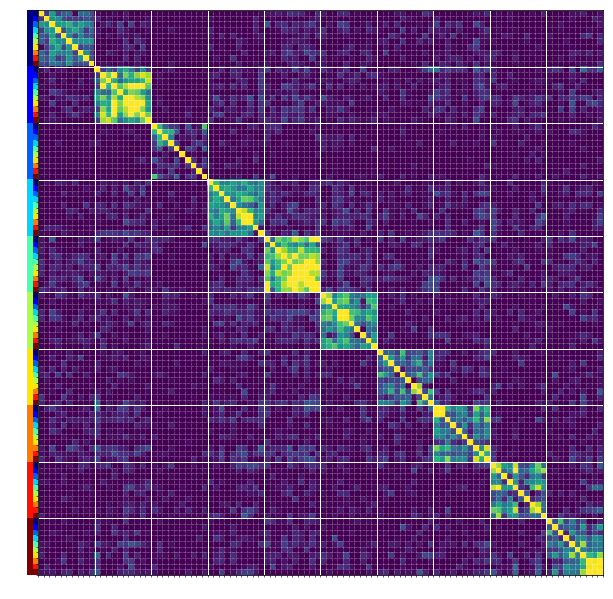

In [9]:
niwaves.simil_plot(simil=groupcorr, within=len(sessions))

In the similarity matrix, the bold white lines separate subjects, while the fainter lines separate sessions. The coloured bars at left are coded according to subject (left bar) and session (right bar) identity. Stronger correspondences are coloured yellos, while weaker correspondences are blue. From examining the similarity matrix, we can see that within-subject similarities (diagonal elements of the larger, bold white grid) are in general substantially greater than between-subject similarities. However, it must again be cautioned that even the maximum yellow colour in the figure corresponds to a fairly weak correlation of 0.08, with the strongest within-subject similarities values on the order of 0.1. While this is substantially greater than between-subject similarities, the effect is nonetheless small.

Finally, as an additional exploration of the data, we run a PCA across sessions. (This PCA is run on the sessions by lags matrix; this is *not* a lag threads analysis.) The PCA is not particularly top-heavy; variance isn't strongly concentrated in the top components.

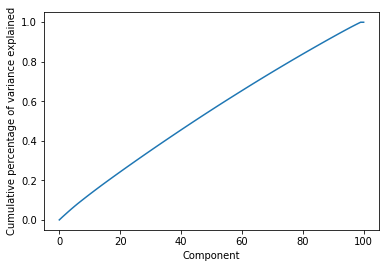

In [10]:
pca = decomposition.PCA()
# For newer versions of sklearn, use this
#imp = sklearn.impute.SimpleImputer(missing_values=np.nan, strategy='constant')
imp = preprocessing.Imputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(groupr.values.T)

# Impute our data, then train
groupr_imp = imp.transform(groupr.values.T)
pcs = pca.fit_transform(groupr_imp)

plt.figure()
plt.plot(np.hstack([[0], np.cumsum(pca.explained_variance_ratio_)]))
plt.xlabel('Component')
plt.ylabel('Cumulative percentage of variance explained');

Finally, we plot the first few components; they don't tell us much, but they indicate that the initial directions of variance superficially more resemble the group average matrix than they do subject-specific features.

/home/vagrant/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


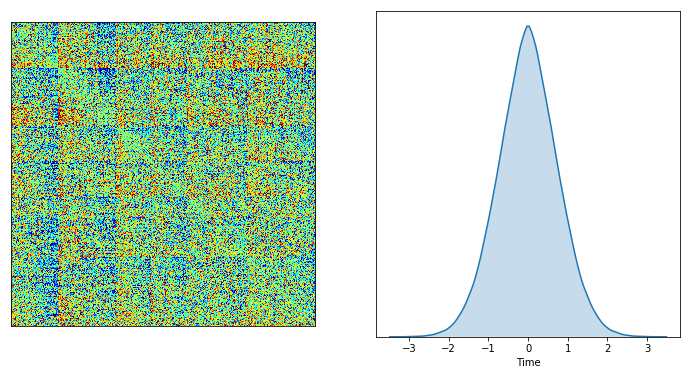

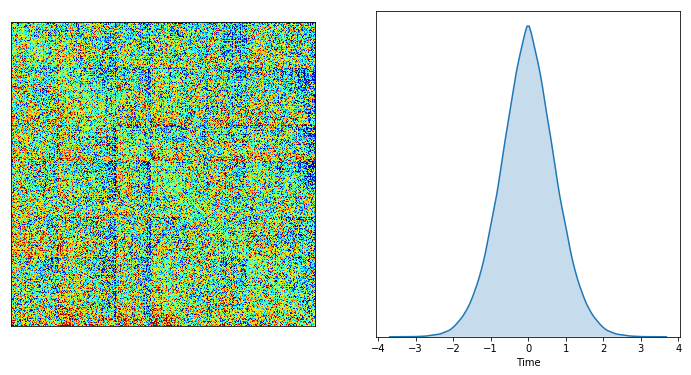

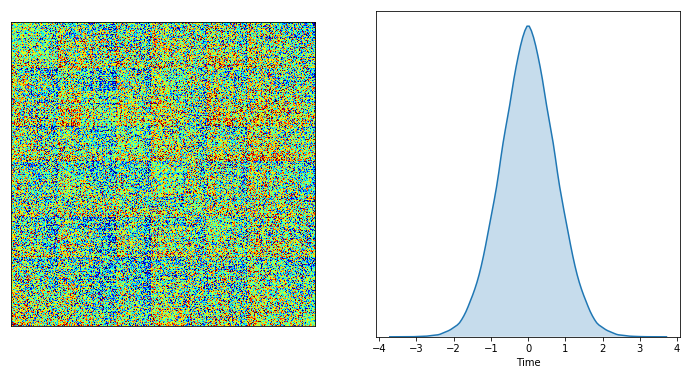

In [12]:
niwaves.lag_sort(pca.components_[0,:].reshape(400,400)*300, community=community)
niwaves.lag_sort(pca.components_[1,:].reshape(400,400)*300, community=community)
niwaves.lag_sort(pca.components_[2,:].reshape(400,400)*300, community=community)

### References

1. Poldrack RA, Laumann TO, Koyejo O, Gregory B, Hover A, Chen MY, Gorgolewski KJ, Luci J, Joo SJ, Boyd RL, Hunicke-Smith S, Simpson ZB, Caven T, Sochat V, Shine JM, Gordon E, Snyder AZ, Adeyemo B, Petersen SE, Glahn DC, Reese Mckay D, Curran JE, Göring HH, Carless MA, Blangero J, Dougherty R, Leemans A, Handwerker DA, Frick L, Marcotte EM, Mumford JA (2015) Long-term neural and physiological phenotyping of a single human. Nat Commun Dec 9;6:8885.

2. Gordon EM, Laumann TO, Gilmore AW, Newbold DJ, Greene DJ, Berg JJ, Ortega M, Hoyt-Drazen C, Gratton C, Sun H, Hampton JM, Coalson RS, Nguyen AL, McDermott KB, Shimony JS, Snyder AZ, Schlaggar BL, Petersen SE, Nelson SM, Dosenbach NUF (2017) Precision Functional Mapping of Individual Human Brains. Neuron 95(4):791-807.e7.

3. Laumann TO, Gordon EM, Adeyemo B, Snyder AZ, Joo SJ, Chen MY, Gilmore AW, McDermott KB, Nelson SM, Dosenbach NU, Schlaggar BL, Mumford JA, Poldrack RA, Petersen SE (2015) Neuron 87(3):657-70. doi: 10.1016/j.neuron.2015.06.037.

4. Gratton C, Laumann TO, Nielsen AN, Greene DJ, Gordon EM, Gilmore AW, Nelson SM, Coalson RS, Snyder AZ, Schlaggar BL, Dosenbach NUF, Petersen SE (2018) Neuron Apr 18;98(2):439-452.e5.

5. Finn ES, Shen X, Scheinost D, Rosenberg MD, Huang J, Chun MM, Papademetris X, Constable RT (2015) Functional connectome fingerprinting: identifying individuals using patterns of brain connectivity. Nat Neurosci 18(11):1664-71.

6. Satterthwaite TD, Elliott MA, Gerraty RT, Ruparel K, Loughead J, Calkins ME, Eickhoff SB, Hakonarson H, Gur RC, Gur RE, Wolf DH (2013) An improved framework for confound regression and filtering for control of motion artifact in the preprocessing of resting-state functional connectivity data. Neuroimage 64:240-56.

7. Schaefer A, Kong R, Gordon EM, Laumann TO, Zuo XN, Holmes AJ, Eickhoff SB, Yeo BTT (2018) Local-Global Parcellation of the Human Cerebral Cortex from Intrinsic Functional Connectivity MRI. Cereb Cortex 28(9):3095-3114.

8. Yeo BT, Krienen FM, Sepulcre J, Sabuncu MR, Lashkari D, Hollinshead M, Roffman JL, Smoller JW, Zöllei L, Polimeni JR, Fischl B, Liu H, Buckner RL (2011) The organization of the human cerebral cortex estimated by intrinsic functional connectivity. J Neurophysiol 106(3):1125-65.